In [1]:
from tinytag import TinyTag
import librosa
import os
import re
import numpy as np
from torch.utils.data import Dataset
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import random
import torch.optim as optim
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.model_selection import KFold
from torch.utils.data import SubsetRandomSampler


In [2]:
class RekordboxAudioDataset(Dataset):
    def __init__(self, audio_dir, transform=None, target_length=1292):
        super().__init__()
        self.audio_dir = audio_dir
        self.transform = transform
        self.target_length = target_length
        self.audio_files = []
        self.true_tempos = []
        self.features = []
        
        self._load_audio_files()
        
    def _pad_or_truncate_features(self, features):
        if features.shape[1] < self.target_length:
            padded = np.zeros((features.shape[0], self.target_length))
            padded[:, :features.shape[1]] = features
            return padded
        return features[:, :self.target_length]
        
    def __len__(self):
        return len(self.audio_files)
    
    def normalize_tempo(self, librosa_tempo, true_tempo):
        while librosa_tempo < 78:
            librosa_tempo *= 2
        while librosa_tempo > 155:
            librosa_tempo /= 2
            
        if librosa_tempo * 2 <= 155:
            if abs(librosa_tempo * 2 - true_tempo) < abs(librosa_tempo - true_tempo):
                librosa_tempo *= 2
        if librosa_tempo / 2 >= 78:
            if abs(librosa_tempo / 2 - true_tempo) < abs(librosa_tempo - true_tempo):
                librosa_tempo /= 2
                
        return librosa_tempo
    
    def _extract_features(self, y, sr, true_tempo):
        try:
            # Use librosa to estimate tempo
            onset_env = librosa.onset.onset_strength(y=y, sr=sr)
            tempo_librosa, _ = librosa.beat.beat_track(onset_envelope=onset_env, sr=sr)
            
            # Normalize the estimated tempo
            tempo_librosa = self.normalize_tempo(tempo_librosa, true_tempo)
            
            # Normalize librosa estimated tempo to [0,1]
            tempo_librosa_norm = (tempo_librosa - 78) / 77
            
            # Compute MFCCs
            mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
            mfccs = librosa.util.fix_length(mfccs, size=self.target_length)
            
            # Compute spectral centroid
            spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)
            spectral_centroid = librosa.util.fix_length(spectral_centroid, size=self.target_length)
            
            mfccs = (mfccs - np.mean(mfccs, axis=1, keepdims=True)) / (np.std(mfccs, axis=1, keepdims=True) + 1e-8)
    
            # Normalize spectral centroid
            spectral_centroid = (spectral_centroid - np.mean(spectral_centroid)) / (np.std(spectral_centroid) + 1e-8)
            
            # Stack features
            tempo_feature = np.full((1, self.target_length), tempo_librosa_norm)
            features = np.vstack([tempo_feature, mfccs, spectral_centroid])
            
            return features
        except Exception as e:
            print(f"Error extracting features: {str(e)}")
            return np.zeros((15, self.target_length))
    
    def _load_audio_files(self):
        tempo_pattern = re.compile(r'^(\d+\.?\d*)\s+(.+)$')
        all_audio_files = [f for f in os.listdir(self.audio_dir) 
                        if f.endswith(('.mp3', '.wav', '.aiff', '.m4a'))]
        
        for filename in all_audio_files:
            match = tempo_pattern.match(filename)
            if match:
                try:
                    true_tempo = float(match.group(1))
                    audio_path = os.path.join(self.audio_dir, filename)
                    
                    tag = TinyTag.get(audio_path)
                    offset = tag.duration / 3 if tag.duration else 0
                    y, sr = librosa.load(audio_path, offset=offset, duration=30)
                    
                    features = self._extract_features(y, sr, true_tempo)
                    features = self._pad_or_truncate_features(features)
                    
                    self.audio_files.append(filename)
                    self.true_tempos.append(true_tempo)
                    self.features.append(features)
                    
                except Exception as e:
                    print(f"Error processing {filename}: {str(e)}")
                    continue
            else:
                continue  # If filename doesn't match the pattern, skip it
    
    def __getitem__(self, idx):
        true_tempo = self.true_tempos[idx]
        features = self.features[idx]
        
        if self.transform:
            features = self.transform(features)
        
        features = torch.FloatTensor(features)
        # Normalize the true tempo for the target
        true_tempo_norm = (true_tempo - 78) / 77
        target = torch.tensor([true_tempo_norm], dtype=torch.float32)
        
        return features, target

In [3]:
class AugmentedRekordboxDataset(Dataset):
    def __init__(self, base_dataset, augmentations_per_sample=4):
        self.base_dataset = base_dataset
        self.augmentations_per_sample = augmentations_per_sample
        self.feature_length = base_dataset.target_length
        self.feature_shape = (15, self.feature_length)

    def __len__(self):
        return len(self.base_dataset) * self.augmentations_per_sample

    def __getitem__(self, idx):
        original_idx = idx // self.augmentations_per_sample
        features, target = self.base_dataset[original_idx]
        original_tempo_norm = features[0, 0].item()  # Get the original tempo feature

        if idx % self.augmentations_per_sample == 0:
            return features, target

        features_np = features.numpy()
        aug_type = idx % self.augmentations_per_sample

        if aug_type == 1:
            features_np, new_tempo_norm, stretch_factor = self._time_stretch(features_np, original_tempo_norm)
            
            # Adjust the target tempo
            # Convert normalized target back to BPM
            target_bpm = target.item() * 77 + 78
            # Adjust tempo BPM according to stretch factor
            new_target_bpm = target_bpm / stretch_factor
            # Normalize the adjusted BPM back to [0, 1]
            new_target_norm = (new_target_bpm - 78) / 77
            target = torch.tensor([new_target_norm], dtype=torch.float32)

        elif aug_type == 2:
            features_np = self._mask_augment(features_np)

        elif aug_type == 3:
            features_np = self._add_noise(features_np)

        return torch.FloatTensor(features_np), target

    def _time_stretch(self, features, original_tempo_norm):
        stretch_factor = np.random.uniform(0.95, 1.05)
        dynamic_features = features[1:]  # Exclude tempo feature

        # Convert original tempo feature back to BPM
        tempo_bpm = original_tempo_norm * 77 + 78
        # Adjust tempo BPM according to stretch factor
        new_tempo_bpm = tempo_bpm / stretch_factor
        # Normalize the adjusted BPM back to [0, 1]
        new_tempo_norm = (new_tempo_bpm - 78) / 77
        features[0] = new_tempo_norm

        time_axis = self.feature_length
        stretched_length = int(time_axis * stretch_factor)

        stretched = np.zeros((features.shape[0], time_axis))
        stretched[0] = features[0]  # Updated tempo feature

        indices = np.linspace(0, time_axis - 1, stretched_length)
        for i in range(dynamic_features.shape[0]):
            # Time-stretch dynamic features
            temp = np.interp(indices, np.arange(time_axis), dynamic_features[i])
            stretched[i + 1] = np.interp(np.arange(time_axis), np.arange(stretched_length), temp)

        return stretched, new_tempo_norm, stretch_factor

    def _mask_augment(self, features):
        features = features.copy()
        mask_size = random.randint(32, min(128, self.feature_length))
        mask_start = random.randint(0, self.feature_length - mask_size)
        features[1:, mask_start:mask_start + mask_size] = 0  # Mask dynamic features
        return features

    def _add_noise(self, features):
        noise = np.random.normal(0, 0.01, (features.shape[0], self.feature_length))
        noise[0] = 0  # Don't add noise to tempo feature
        return features + noise

In [4]:
# Initialize datasets
audio_dir = "./TellerNet/data/beatbank_train_audios"
base_dataset = RekordboxAudioDataset(audio_dir, target_length=1292)
aug_dataset = AugmentedRekordboxDataset(base_dataset)

# Verify shapes
if len(base_dataset) > 0:
    base_features, base_target = base_dataset[0]
    print(f"Base shape: {base_features.shape}")
    print(f"Base target: {base_target}")
else:
    print("Base dataset is empty.")

if len(aug_dataset) > 0:
    aug_features, aug_target = aug_dataset[0]
    print(f"Augmented shape: {aug_features.shape}")
    print(f"Augmented target: {aug_target}")
else:
    print("Augmented dataset is empty.")

Base shape: torch.Size([15, 1292])
Base target: tensor([0.2857])
Augmented shape: torch.Size([15, 1292])
Augmented target: tensor([0.2857])


In [5]:
# Dataset parameters
target_length = 1292  # Length to pad or truncate features
batch_size = 32       # Increased batch size for more stable gradients
test_size = 0.2       # Fraction of data to use for validation
random_seed = 42     # Random seed for reproducibility

# Training parameters
num_epochs = 1200       # Number of epochs for training
learning_rate = 0.0002 # Reduced learning rate for optimizer

# Model parameters
input_channels = 15   # Number of feature channels

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Set random seeds for reproducibility
import random
import numpy as np

random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(random_seed)

In [6]:
# Define scaling and descaling functions
def scale_tempo(tempo):
    return (tempo - 78) / 77

def descale_tempo(scaled_tempo):
    return scaled_tempo * 77 + 78

# Split the dataset into training and validation sets
from sklearn.model_selection import train_test_split

# Get indices for splitting
dataset_size = len(aug_dataset)
indices = list(range(dataset_size))
train_indices, val_indices = train_test_split(
    indices, test_size=test_size, random_state=random_seed, shuffle=True
)

# Create samplers
from torch.utils.data.sampler import SubsetRandomSampler

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_loader = DataLoader(aug_dataset, batch_size=batch_size, sampler=train_sampler)
val_loader = DataLoader(aug_dataset, batch_size=batch_size, sampler=val_sampler)

# Define the CNN model
class TellerNet(nn.Module):
    def __init__(self):
        super(TellerNet, self).__init__()
        self.input_bn = nn.BatchNorm1d(input_channels)
        self.conv1 = nn.Conv1d(in_channels=input_channels, out_channels=32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm1d(32, momentum=0.1)
        self.pool1 = nn.MaxPool1d(kernel_size=2)

        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm1d(64, momentum=0.1)
        self.pool2 = nn.MaxPool1d(kernel_size=2)

        self.conv3 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm1d(128, momentum=0.1)
        self.pool3 = nn.MaxPool1d(kernel_size=2)

        # Calculate the output length after convolution and pooling
        conv_output_length = self._calculate_output_length(target_length)
        self.fc1 = nn.Linear(128 * conv_output_length, 256)
        self.fc2 = nn.Linear(256, 1)  # Output is a single value (scaled tempo)

    def _calculate_output_length(self, input_length):
        # Calculate the length after three pooling layers
        length = input_length
        for _ in range(3):
            length = length // 2  # MaxPool with kernel_size=2 halves the length
        return length

    def forward(self, x):
        x = self.input_bn(x)
        x = self.pool1(nn.functional.relu(self.bn1(self.conv1(x))))
        x = self.pool2(nn.functional.relu(self.bn2(self.conv2(x))))
        x = self.pool3(nn.functional.relu(self.bn3(self.conv3(x))))
        x = x.view(x.size(0), -1)
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x.squeeze()

# Initialize the model, loss function, optimizer, and scheduler
model = TellerNet().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10)


In [7]:
train_losses = []
val_losses = []
train_bpm_errors = []
val_bpm_errors = []
best_val_loss = float('inf')
best_model_state = None
epochs_without_improvement = 0
patience = 200  # Early stopping patience

for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    running_bpm_error = 0.0
    for features, targets in train_loader:
        features = features.to(device).permute(0, 1, 2)  # Ensure features are (batch_size, channels, length)
        targets = targets.to(device)
        optimizer.zero_grad()
        outputs = model(features)
        loss = criterion(outputs, targets.squeeze())
        loss.backward()
        # Apply gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        running_loss += loss.item() * features.size(0)

        # Compute BPM error
        predicted_tempo = descale_tempo(outputs.detach().cpu())
        true_tempo = descale_tempo(targets.squeeze().cpu())
        bpm_error = torch.abs(predicted_tempo - true_tempo)
        running_bpm_error += bpm_error.sum().item()

    epoch_train_loss = running_loss / len(train_indices)
    epoch_train_bpm_error = running_bpm_error / len(train_indices)
    train_losses.append(epoch_train_loss)
    train_bpm_errors.append(epoch_train_bpm_error)

    # Validation phase
    model.eval()
    running_val_loss = 0.0
    running_val_bpm_error = 0.0
    with torch.no_grad():
        for features, targets in val_loader:
            features = features.to(device).permute(0, 1, 2)  # Ensure features are (batch_size, channels, length)
            targets = targets.to(device)
            outputs = model(features)
            loss = criterion(outputs, targets.squeeze())
            running_val_loss += loss.item() * features.size(0)

            # Compute BPM error
            predicted_tempo = descale_tempo(outputs.cpu())
            true_tempo = descale_tempo(targets.squeeze().cpu())
            bpm_error = torch.abs(predicted_tempo - true_tempo)
            running_val_bpm_error += bpm_error.sum().item()

    epoch_val_loss = running_val_loss / len(val_indices)
    epoch_val_bpm_error = running_val_bpm_error / len(val_indices)
    val_losses.append(epoch_val_loss)
    val_bpm_errors.append(epoch_val_bpm_error)

    # Step the scheduler
    scheduler.step(epoch_val_loss)

    print(f'Epoch [{epoch+1}/{num_epochs}], '
          f'Train Loss: {epoch_train_loss:.4f}, '
          f'Train BPM Error: {epoch_train_bpm_error:.2f}, '
          f'Validation Loss: {epoch_val_loss:.4f}, '
          f'Validation BPM Error: {epoch_val_bpm_error:.2f}')

    # Early stopping
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        best_model_state = model.state_dict()
        epochs_without_improvement = 0
    else:
        epochs_without_improvement += 1
        if epochs_without_improvement >= patience:
            print("Early stopping triggered.")
            break

# Save the best model to a .pth file
now = datetime.now()
dt_string = now.strftime("%Y%m%d_%H%M%S")
torch.save(best_model_state, f'model_{dt_string}.pth')

print("Best model saved to 'best_tempo_estimation_model.pth'")
print("average bpm error for best model: ", np.mean(val_bpm_errors))

Epoch [1/1200], Train Loss: 5.0638, Train BPM Error: 84.69, Validation Loss: 0.1137, Validation BPM Error: 18.78
Epoch [2/1200], Train Loss: 0.0398, Train BPM Error: 11.27, Validation Loss: 0.0572, Validation BPM Error: 14.11
Epoch [3/1200], Train Loss: 0.0194, Train BPM Error: 7.76, Validation Loss: 0.0161, Validation BPM Error: 7.07
Epoch [4/1200], Train Loss: 0.0117, Train BPM Error: 6.04, Validation Loss: 0.0110, Validation BPM Error: 5.50
Epoch [5/1200], Train Loss: 0.0194, Train BPM Error: 8.38, Validation Loss: 0.0112, Validation BPM Error: 5.16
Epoch [6/1200], Train Loss: 0.0162, Train BPM Error: 7.10, Validation Loss: 0.0084, Validation BPM Error: 5.06
Epoch [7/1200], Train Loss: 0.0060, Train BPM Error: 4.34, Validation Loss: 0.0061, Validation BPM Error: 4.10
Epoch [8/1200], Train Loss: 0.0053, Train BPM Error: 3.82, Validation Loss: 0.0108, Validation BPM Error: 6.17
Epoch [9/1200], Train Loss: 0.0045, Train BPM Error: 3.81, Validation Loss: 0.0153, Validation BPM Error: 8.

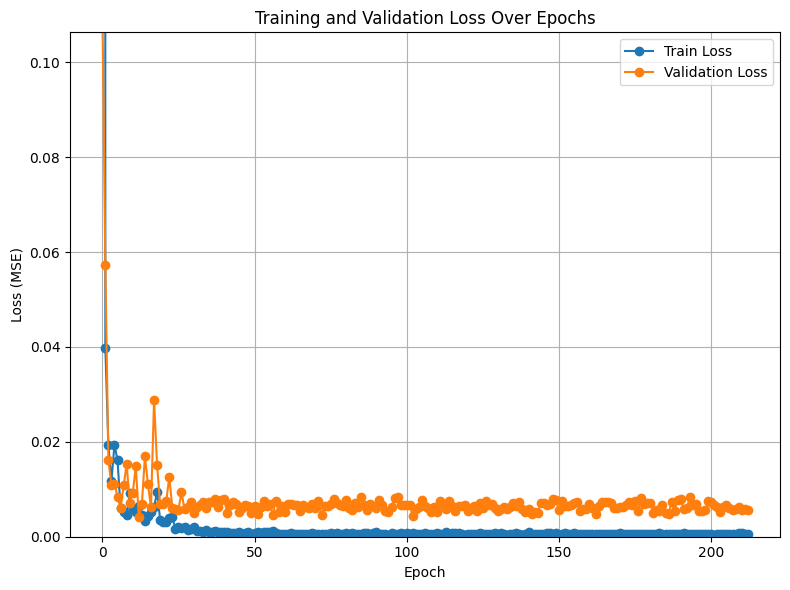

Loss plot saved to c:\Users\parke\OneDrive\Documents\GitHub\beat_teller_project\plots\training_validation_losses_20241203_183958.png


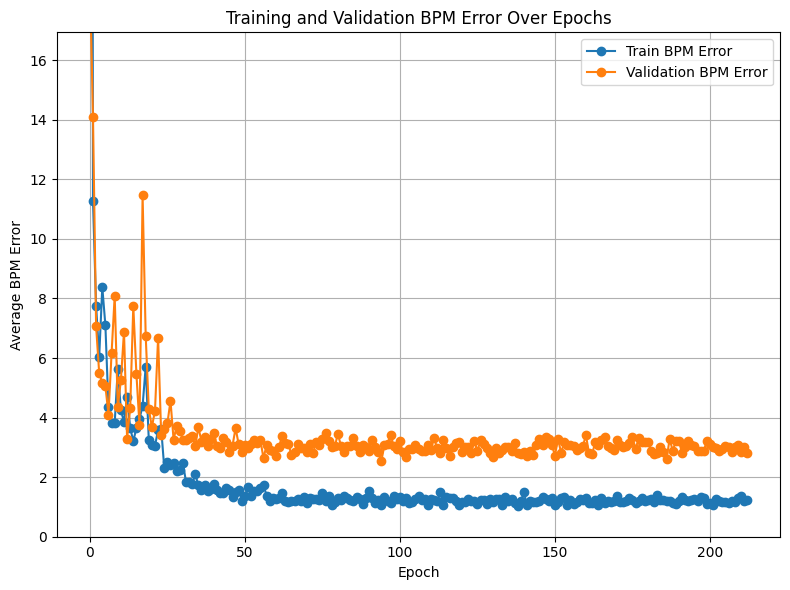

BPM error plot saved to c:\Users\parke\OneDrive\Documents\GitHub\beat_teller_project\plots\training_validation_bpm_errors_20241203_183958.png


In [8]:
# Create directories for plots if they don't exist
plt_dir = os.path.join(os.getcwd(), 'plots')
os.makedirs(plt_dir, exist_ok=True)

# Generate epochs range
epochs_range = list(range(len(train_losses)))

# Plot Training and Validation Loss in a separate figure
plt.figure(figsize=(8, 6))
plt.plot(epochs_range, train_losses, label='Train Loss', marker='o')
plt.plot(epochs_range, val_losses, label='Validation Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.ylim([0, max(train_losses + val_losses) * .021])  # Adjust as needed
# Optionally use logarithmic scale
# plt.yscale('log')
plt.tight_layout()
now = datetime.now()
dt_string = now.strftime("%Y%m%d_%H%M%S")
loss_plot_filename = os.path.join(plt_dir, f'training_validation_losses_{dt_string}.png')
plt.savefig(loss_plot_filename)
plt.show()

print(f"Loss plot saved to {loss_plot_filename}")

# Plot Training and Validation BPM Error in a separate figure
plt.figure(figsize=(8, 6))
plt.plot(epochs_range, train_bpm_errors, label='Train BPM Error', marker='o')
plt.plot(epochs_range, val_bpm_errors, label='Validation BPM Error', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Average BPM Error')
plt.title('Training and Validation BPM Error Over Epochs')
plt.legend()
plt.grid(True)
# Adjust y-axis limits based on BPM error values
plt.ylim([0, max(train_bpm_errors + val_bpm_errors) * .2])
plt.tight_layout()
bpm_error_plot_filename = os.path.join(plt_dir, f'training_validation_bpm_errors_{dt_string}.png')
plt.savefig(bpm_error_plot_filename)
plt.show()

print(f"BPM error plot saved to {bpm_error_plot_filename}")

# K Fold Cross Validation

In [10]:
num_epochs = 1200
learning_rate = 0.0005
batch_size = 64
patience = 20  # Early stopping patience
k_folds = 5
random_seed = 24

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Ensure reproducibility
torch.manual_seed(random_seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(random_seed)
np.random.seed(random_seed)

# Initialize the dataset
audio_dir = "./TellerNet/data/beatbank_train_audios"
base_dataset = RekordboxAudioDataset(audio_dir, target_length=1292)
aug_dataset = AugmentedRekordboxDataset(base_dataset)

# Prepare cross-validation
kfold = KFold(n_splits=k_folds, shuffle=True, random_state=random_seed)

# Lists to hold overall performance metrics
fold_train_losses = []
fold_val_losses = []
fold_train_bpm_errors = []
fold_val_bpm_errors = []

# Start cross-validation
for fold, (train_indices, val_indices) in enumerate(kfold.split(aug_dataset)):
    print(f'\nFold {fold+1}/{k_folds}')
    print('--------------------------------')
    
    # Sample elements randomly from the dataset, no replacement.
    train_sampler = SubsetRandomSampler(train_indices)
    val_sampler = SubsetRandomSampler(val_indices)
    
    # Define data loaders for training and validation
    train_loader = DataLoader(aug_dataset, batch_size=batch_size, sampler=train_sampler)
    val_loader = DataLoader(aug_dataset, batch_size=batch_size, sampler=val_sampler)
    
    # Initialize the model, optimizer, loss function, and scheduler for each fold
    model = TellerNet().to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10)
    criterion = nn.MSELoss()
    
    # Track metrics for this fold
    train_losses = []
    val_losses = []
    train_bpm_errors = []
    val_bpm_errors = []
    best_val_loss = float('inf')
    best_model_state = None
    epochs_without_improvement = 0
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        running_bpm_error = 0.0
        for features, targets in train_loader:
            features = features.to(device).permute(0, 1, 2)
            targets = targets.to(device)
            optimizer.zero_grad()
            outputs = model(features)
            loss = criterion(outputs, targets.squeeze())
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            running_loss += loss.item() * features.size(0)

            # Compute BPM error
            predicted_tempo = descale_tempo(outputs.detach().cpu())
            true_tempo = descale_tempo(targets.squeeze().cpu())
            bpm_error = torch.abs(predicted_tempo - true_tempo)
            running_bpm_error += bpm_error.sum().item()
        
        epoch_train_loss = running_loss / len(train_indices)
        epoch_train_bpm_error = running_bpm_error / len(train_indices)
        train_losses.append(epoch_train_loss)
        train_bpm_errors.append(epoch_train_bpm_error)
        
        # Validation phase
        model.eval()
        running_val_loss = 0.0
        running_val_bpm_error = 0.0
        with torch.no_grad():
            for features, targets in val_loader:
                features = features.to(device).permute(0, 1, 2)
                targets = targets.to(device)
                outputs = model(features)
                loss = criterion(outputs, targets.squeeze())
                running_val_loss += loss.item() * features.size(0)

                # Compute BPM error
                predicted_tempo = descale_tempo(outputs.cpu())
                true_tempo = descale_tempo(targets.squeeze().cpu())
                bpm_error = torch.abs(predicted_tempo - true_tempo)
                running_val_bpm_error += bpm_error.sum().item()
        
        epoch_val_loss = running_val_loss / len(val_indices)
        epoch_val_bpm_error = running_val_bpm_error / len(val_indices)
        val_losses.append(epoch_val_loss)
        val_bpm_errors.append(epoch_val_bpm_error)
        
        # Step the scheduler
        scheduler.step(epoch_val_loss)
        
        print(f'Epoch [{epoch+1}/{num_epochs}], '
              f'Train Loss: {epoch_train_loss:.4f}, '
              f'Train BPM Error: {epoch_train_bpm_error:.2f}, '
              f'Validation Loss: {epoch_val_loss:.4f}, '
              f'Validation BPM Error: {epoch_val_bpm_error:.2f}')
        
        # Early stopping
        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            best_model_state = model.state_dict()
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1
            if epochs_without_improvement >= patience:
                print("Early stopping triggered.")
                break
    
    # Save the best model for this fold
    now = datetime.now()
    dt_string = now.strftime("%Y%m%d_%H%M%S")
    model_filename = f'model_fold{fold+1}_{dt_string}.pth'
    torch.save(best_model_state, model_filename)
    print(f"Best model for fold {fold+1} saved to '{model_filename}'")
    
    # Store metrics for this fold
    fold_train_losses.append(train_losses)
    fold_val_losses.append(val_losses)
    fold_train_bpm_errors.append(train_bpm_errors)
    fold_val_bpm_errors.append(val_bpm_errors)

# After all folds, compute average metrics
avg_train_loss = np.mean([losses[-1] for losses in fold_train_losses])
avg_val_loss = np.mean([losses[-1] for losses in fold_val_losses])
avg_train_bpm_error = np.mean([errors[-1] for errors in fold_train_bpm_errors])
avg_val_bpm_error = np.mean([errors[-1] for errors in fold_val_bpm_errors])

print('\nCross-Validation Results')
print('------------------------')
print(f'Average Train Loss: {avg_train_loss:.4f}')
print(f'Average Validation Loss: {avg_val_loss:.4f}')
print(f'Average Train BPM Error: {avg_train_bpm_error:.2f}')
print(f'Average Validation BPM Error: {avg_val_bpm_error:.2f}')


Fold 1/5
--------------------------------
Epoch [1/1200], Train Loss: 110.2517, Train BPM Error: 534.85, Validation Loss: 0.4744, Validation BPM Error: 47.57
Epoch [2/1200], Train Loss: 0.4861, Train BPM Error: 42.18, Validation Loss: 0.2262, Validation BPM Error: 27.49
Epoch [3/1200], Train Loss: 0.2335, Train BPM Error: 27.32, Validation Loss: 0.2253, Validation BPM Error: 27.19
Epoch [4/1200], Train Loss: 0.2296, Train BPM Error: 26.97, Validation Loss: 0.2145, Validation BPM Error: 26.52
Epoch [5/1200], Train Loss: 0.2254, Train BPM Error: 26.59, Validation Loss: 0.2130, Validation BPM Error: 26.23
Epoch [6/1200], Train Loss: 0.2197, Train BPM Error: 26.09, Validation Loss: 0.2060, Validation BPM Error: 25.66
Epoch [7/1200], Train Loss: 0.2175, Train BPM Error: 25.91, Validation Loss: 0.2056, Validation BPM Error: 25.57
Epoch [8/1200], Train Loss: 0.2146, Train BPM Error: 25.59, Validation Loss: 0.1980, Validation BPM Error: 25.06
Epoch [9/1200], Train Loss: 0.2095, Train BPM Erro

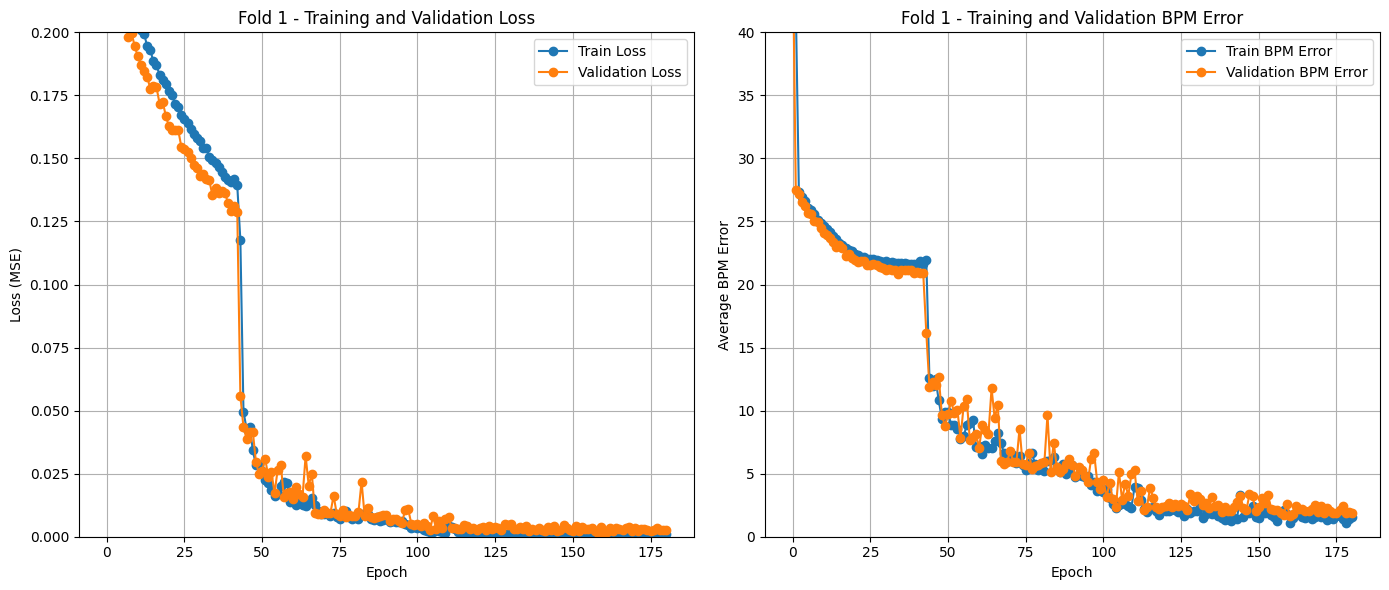

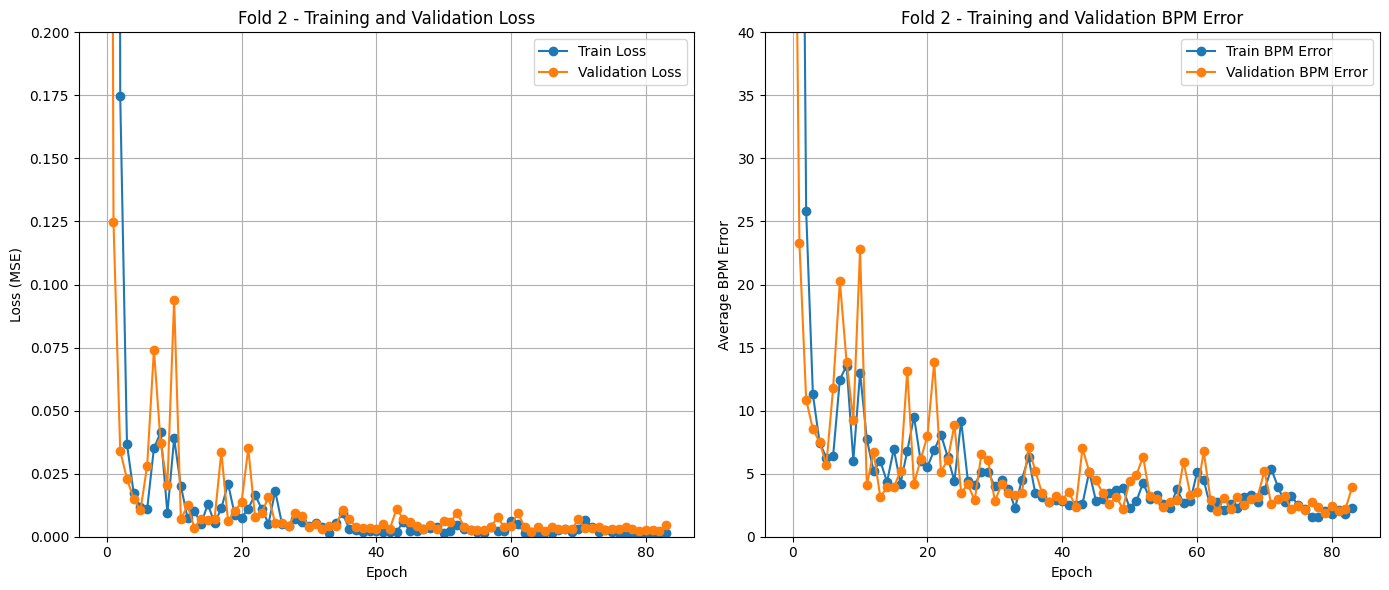

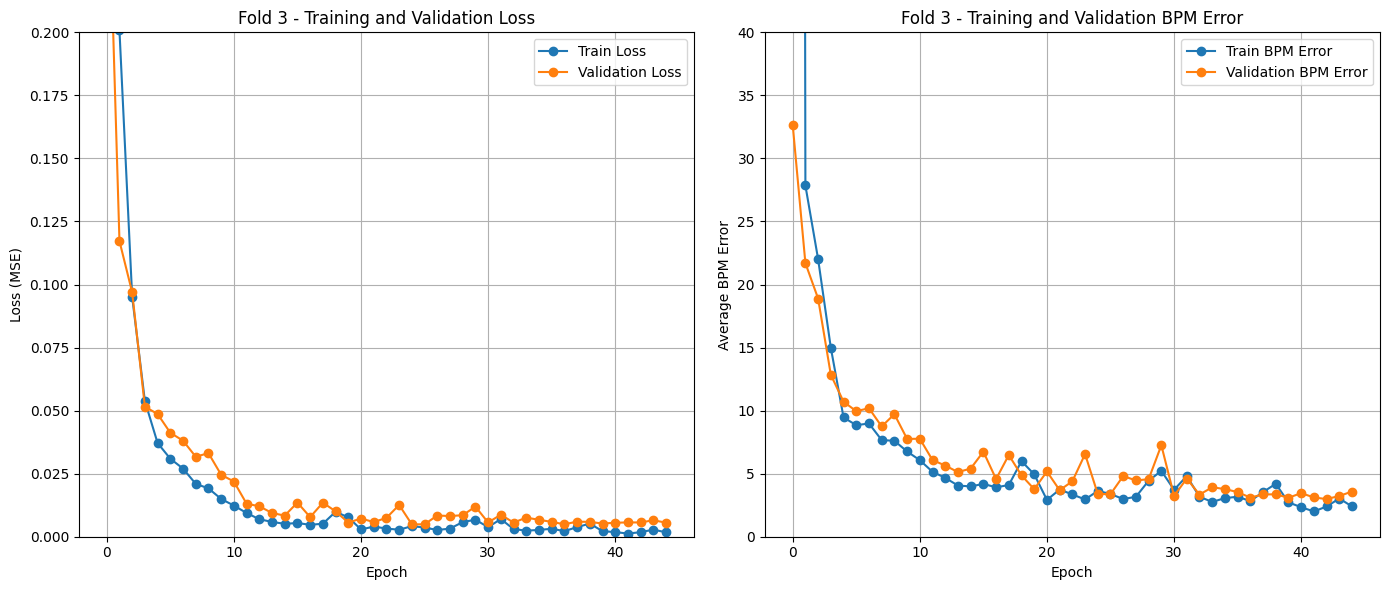

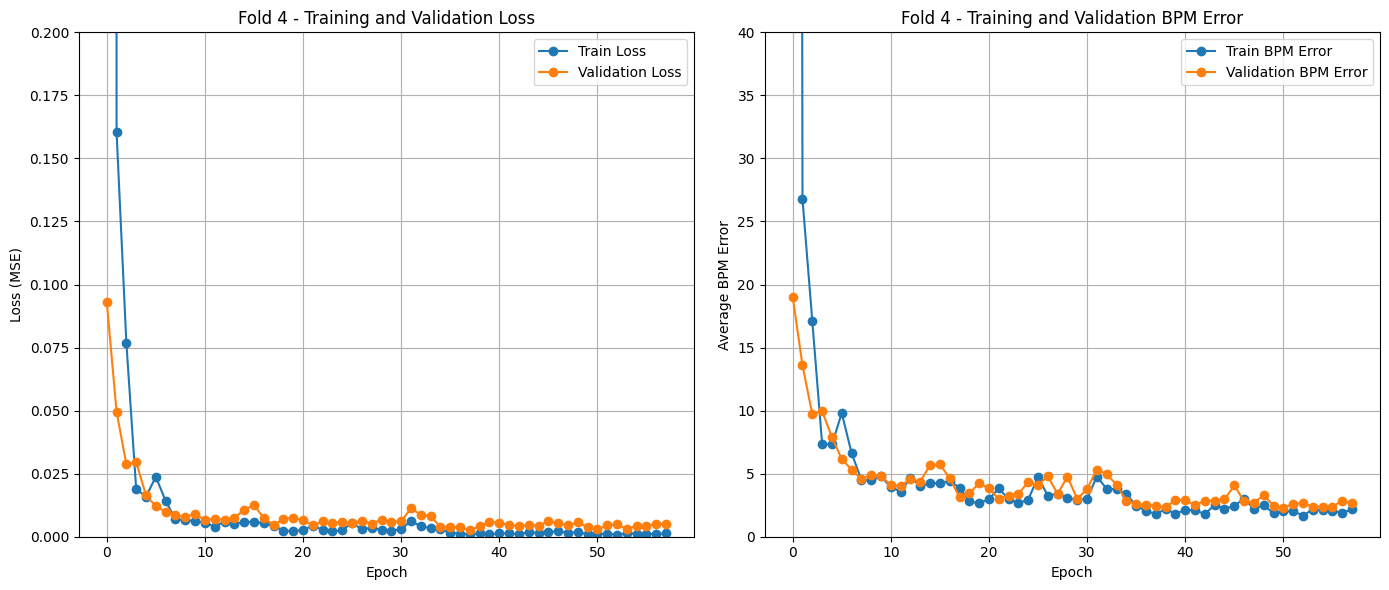

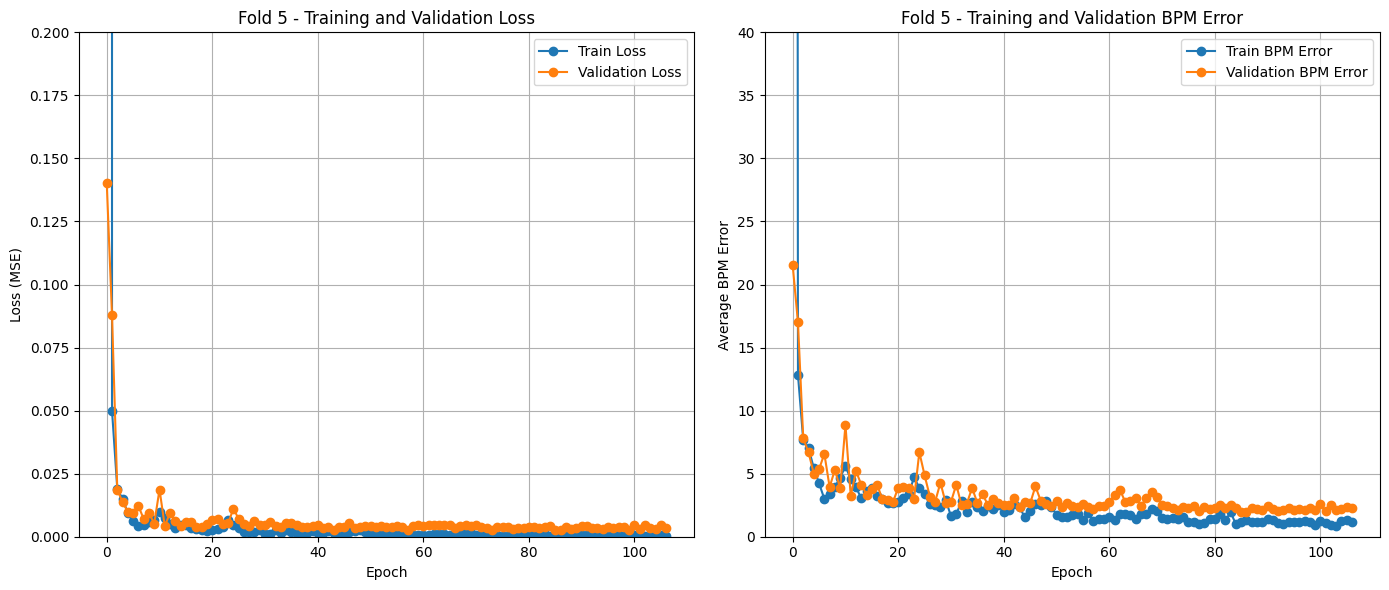

K-Fold Cross Validation Results Summary
Fold 1:
  Final Training Loss: 0.0009
  Final Validation Loss: 0.0028
  Final Training BPM Error: 1.56
  Final Validation BPM Error: 1.91
---------------------------------------
Fold 2:
  Final Training Loss: 0.0015
  Final Validation Loss: 0.0047
  Final Training BPM Error: 2.29
  Final Validation BPM Error: 3.91
---------------------------------------
Fold 3:
  Final Training Loss: 0.0017
  Final Validation Loss: 0.0056
  Final Training BPM Error: 2.40
  Final Validation BPM Error: 3.58
---------------------------------------
Fold 4:
  Final Training Loss: 0.0013
  Final Validation Loss: 0.0050
  Final Training BPM Error: 2.18
  Final Validation BPM Error: 2.66
---------------------------------------
Fold 5:
  Final Training Loss: 0.0005
  Final Validation Loss: 0.0036
  Final Training BPM Error: 1.14
  Final Validation BPM Error: 2.26
---------------------------------------
Overall Cross-Validation Performance:
  Average Training Loss: 0.0012


<Figure size 640x480 with 0 Axes>

In [11]:
for fold in range(k_folds):
    epochs_range = list(range(len(fold_train_losses[fold])))
    plt.figure(figsize=(14, 6))
    
    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, fold_train_losses[fold], label='Train Loss', marker='o')
    plt.plot(epochs_range, fold_val_losses[fold], label='Validation Loss', marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (MSE)')
    plt.ylim(0, .2)
    plt.title(f'Fold {fold+1} - Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    
    # BPM error plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, fold_train_bpm_errors[fold], label='Train BPM Error', marker='o')
    plt.plot(epochs_range, fold_val_bpm_errors[fold], label='Validation BPM Error', marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Average BPM Error')
    plt.title(f'Fold {fold+1} - Training and Validation BPM Error')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    # set y range between 0 and 100
    plt.ylim(0, 40)
    plt.show()

plt.tight_layout()
# Text summary
print("K-Fold Cross Validation Results Summary")
print("=======================================")
for fold in range(k_folds):
    print(f"Fold {fold + 1}:")
    print(f"  Final Training Loss: {fold_train_losses[fold][-1]:.4f}")
    print(f"  Final Validation Loss: {fold_val_losses[fold][-1]:.4f}")
    print(f"  Final Training BPM Error: {fold_train_bpm_errors[fold][-1]:.2f}")
    print(f"  Final Validation BPM Error: {fold_val_bpm_errors[fold][-1]:.2f}")
    print("---------------------------------------")

print("Overall Cross-Validation Performance:")
print(f"  Average Training Loss: {avg_train_loss:.4f}")
print(f"  Average Validation Loss: {avg_val_loss:.4f}")
print(f"  Average Training BPM Error: {avg_train_bpm_error:.2f}")
print(f"  Average Validation BPM Error: {avg_val_bpm_error:.2f}")


In [45]:

class BalancedRekordboxDataset(Dataset):
    def __init__(self, base_dataset, augmentations_per_sample=4, include_original=True):
        self.base_dataset = base_dataset
        self.augmentations_per_sample = augmentations_per_sample
        self.include_original = include_original
        self.feature_length = base_dataset.target_length
        self.feature_shape = (15, self.feature_length)
        
        # Calculate total length based on whether we include originals
        self.total_multiplier = augmentations_per_sample + (1 if include_original else 0)
        
    def __len__(self):
        return len(self.base_dataset) * self.total_multiplier
    
    def __getitem__(self, idx):
        # Calculate which sample and which version we want
        original_idx = idx // self.total_multiplier
        version_idx = idx % self.total_multiplier
        
        # Get original features and target
        features, target = self.base_dataset[original_idx]
        original_tempo_norm = features[0, 0].item()
        
        # If we want the original and this is the last index, return original
        if self.include_original and version_idx == self.total_multiplier - 1:
            return features, target
            
        # Otherwise apply augmentation based on version_idx
        features_np = features.numpy()
        
        if version_idx == 0:
            features_np, new_tempo_norm, stretch_factor = self._time_stretch(features_np, original_tempo_norm)
            # Adjust the target tempo
            target_bpm = target.item() * 77 + 78
            new_target_bpm = target_bpm / stretch_factor
            new_target_norm = (new_target_bpm - 78) / 77
            target = torch.tensor([new_target_norm], dtype=torch.float32)
        elif version_idx == 1:
            features_np = self._mask_augment(features_np)
        elif version_idx == 2:
            features_np = self._add_noise(features_np)
        elif version_idx == 3:
            # Add another augmentation type or combine existing ones
            features_np, new_tempo_norm, stretch_factor = self._time_stretch(features_np, original_tempo_norm)
            features_np = self._add_noise(features_np)
            # Adjust target as in time stretch
            target_bpm = target.item() * 77 + 78
            new_target_bpm = target_bpm / stretch_factor
            new_target_norm = (new_target_bpm - 78) / 77
            target = torch.tensor([new_target_norm], dtype=torch.float32)
            
        return torch.FloatTensor(features_np), target
    def _time_stretch(self, features, original_tempo_norm):
        stretch_factor = np.random.uniform(0.95, 1.05)
        dynamic_features = features[1:]  # Exclude tempo feature

        # Convert original tempo feature back to BPM
        tempo_bpm = original_tempo_norm * 77 + 78
        # Adjust tempo BPM according to stretch factor
        new_tempo_bpm = tempo_bpm / stretch_factor
        # Normalize the adjusted BPM back to [0, 1]
        new_tempo_norm = (new_tempo_bpm - 78) / 77
        features[0] = new_tempo_norm

        time_axis = self.feature_length
        stretched_length = int(time_axis * stretch_factor)

        stretched = np.zeros((features.shape[0], time_axis))
        stretched[0] = features[0]  # Updated tempo feature

        indices = np.linspace(0, time_axis - 1, stretched_length)
        for i in range(dynamic_features.shape[0]):
            # Time-stretch dynamic features
            temp = np.interp(indices, np.arange(time_axis), dynamic_features[i])
            stretched[i + 1] = np.interp(np.arange(time_axis), np.arange(stretched_length), temp)

        return stretched, new_tempo_norm, stretch_factor

    def _mask_augment(self, features):
        features = features.copy()
        mask_size = random.randint(32, min(128, self.feature_length))
        mask_start = random.randint(0, self.feature_length - mask_size)
        features[1:, mask_start:mask_start + mask_size] = 0  # Mask dynamic features
        return features

    def _add_noise(self, features):
        noise = np.random.normal(0, 0.01, (features.shape[0], self.feature_length))
        noise[0] = 0  # Don't add noise to tempo feature
        return features + noise

In [46]:
test_audio_dir = os.path.join(os.getcwd(), 'TellerNet', 'data', 'beatbank_inf_audios')

test_dataset = RekordboxAudioDataset(test_audio_dir, target_length=1292)
aug_test_set = BalancedRekordboxDataset(base_dataset, augmentations_per_sample=4, include_original=True)
test_loader = DataLoader(aug_test_set, batch_size=1, shuffle=False)
print(f'successfully loaded {len(test_dataset)} raw files')
print(f'successfully loaded {len(aug_test_set)} augmented files')



successfully loaded 37 raw files
successfully loaded 980 augmented files


# Ensemble vs best model

### Best model

In [47]:
best_model_path = 'model_fold2_20241203_184255.pth'
best_model = TellerNet().to(device)
best_model.load_state_dict(torch.load(best_model_path, map_location=device, weights_only=False))


<All keys matched successfully>

In [56]:
# Function to descale tempo
def descale_tempo(scaled_tempo):
    return scaled_tempo * 77 + 78

# Lists to store results
best_model_predictions = []
best_model_errors = []

test_dataset = RekordboxAudioDataset(test_audio_dir, target_length=1292)
aug_test_set = BalancedRekordboxDataset(base_dataset, augmentations_per_sample=4, include_original=True)
test_loader = DataLoader(aug_test_set, batch_size=1, shuffle=False)


In [57]:
print(f'successfully loaded {len(test_dataset)} raw files')
print(f'successfully loaded {len(aug_test_set)} augmented files')


successfully loaded 37 raw files
successfully loaded 980 augmented files


In [58]:

best_model.eval()
with torch.no_grad():
    for features, target in test_loader:
        features = features.to(device).permute(0, 1, 2)  # Ensure features are (batch_size, channels, length)
        true_tempo_norm = target.item() # Get the true tempo
        true_tempo = descale_tempo(true_tempo_norm) # Descale the true tempo
        output = best_model(features) # Get the model output
        predicted_tempo_norm = output.cpu().item()
        predicted_tempo = descale_tempo(predicted_tempo_norm)
        error = abs(predicted_tempo - true_tempo)
        
        best_model_predictions.append((true_tempo, predicted_tempo, error))
        best_model_errors.append(error)

# Print the results
print("\nInference Results using Best Model :")
print("True Tempo\tPredicted Tempo\tError (BPM)")
for result in best_model_predictions:
    true_tempo, predicted_tempo, error = result
    print(f"{true_tempo:.2f}\t\t{predicted_tempo:.2f}\t\t{error:.2f}")

# Compute average error
average_error_best_model = np.mean(best_model_errors)
print(f"\nAverage BPM Error using Best Model: {average_error_best_model:.2f} BPM")


Inference Results using Best Model :
True Tempo	Predicted Tempo	Error (BPM)
101.31		104.42		3.11
100.00		102.22		2.22
100.00		103.59		3.59
103.92		103.92		0.00
100.00		103.61		3.61
98.09		100.28		2.19
100.00		100.36		0.36
100.00		103.49		3.49
100.38		102.74		2.36
100.00		103.46		3.46
98.67		99.86		1.19
100.00		103.19		3.19
100.00		102.83		2.83
99.05		102.11		3.06
100.00		102.83		2.83
97.03		100.71		3.68
100.00		102.06		2.06
100.00		102.99		2.99
99.90		102.97		3.07
100.00		102.90		2.90
97.73		99.19		1.46
100.00		100.81		0.81
100.00		103.45		3.45
96.86		98.49		1.63
100.00		103.44		3.44
98.64		98.83		0.18
100.00		103.79		3.79
100.00		103.11		3.11
105.04		104.31		0.72
100.00		103.15		3.15
99.83		101.17		1.34
101.00		103.89		2.89
101.00		104.02		3.02
102.69		95.44		7.24
101.00		104.07		3.07
97.56		97.67		0.11
101.00		101.44		0.44
101.00		104.03		3.03
97.18		97.54		0.35
101.00		104.09		3.09
102.44		104.43		2.00
101.00		103.75		2.75
101.00		104.21		3.21
98.08		101.28		3.20
101.00		104.27		3.

In [107]:
# Load all models for the ensemble
model_paths = [
    'pths/model_fold1_20241203_140536.pth',
    'pths/model_fold2_20241203_140553.pth',
    'pths/model_fold3_20241203_140611.pth',
    'pths/model_fold4_20241203_140633.pth',
    'pths/model_fold5_20241203_140716.pth',
]

ensemble_models = []
for path in model_paths:
    model = TellerNet()
    model.to(device)
    model.load_state_dict(torch.load(path, map_location=device, weights_only=False))
    model.eval()
    ensemble_models.append(model)

In [108]:
ensemble_predictions = []
ensemble_errors = []

with torch.no_grad():
    for features, target in test_loader:
        features = features.to(device).permute(0, 1, 2)
        true_tempo_norm = target.item()
        true_tempo = descale_tempo(true_tempo_norm)
        outputs = []
        for model in ensemble_models:
            output = model(features)
            outputs.append(output.cpu().item())
        # Average the outputs
        predicted_tempo_norm = np.mean(outputs)
        predicted_tempo = descale_tempo(predicted_tempo_norm)
        error = abs(predicted_tempo - true_tempo)
        ensemble_predictions.append((true_tempo, predicted_tempo, error))
        ensemble_errors.append(error)

# Print the results
print("\nInference Results using Ensemble of Models:")
print("True Tempo\tPredicted Tempo\tError (BPM)")
for result in ensemble_predictions:
    true_tempo, predicted_tempo, error = result
    print(f"{true_tempo:.2f}\t\t{predicted_tempo:.2f}\t\t{error:.2f}")

# Compute average error
average_error_ensemble = np.mean(ensemble_errors)
print(f"\nAverage BPM Error using Ensemble: {average_error_ensemble:.2f} BPM")


Inference Results using Ensemble of Models:
True Tempo	Predicted Tempo	Error (BPM)
101.12		100.17		0.94
100.00		101.04		1.04
100.00		100.51		0.51
105.05		106.33		1.28
100.00		100.50		0.50
96.86		97.13		0.27
100.00		100.97		0.97
100.00		100.40		0.40
96.82		97.08		0.26
100.00		100.43		0.43
100.99		98.25		2.75
100.00		99.03		0.97
100.00		100.50		0.50
100.69		98.94		1.75
100.00		100.53		0.53
100.59		97.13		3.46
100.00		99.39		0.61
100.00		98.30		1.70
101.80		98.56		3.24
100.00		98.35		1.65
104.11		98.70		5.41
100.00		99.29		0.71
100.00		99.18		0.82
104.13		98.71		5.42
100.00		99.18		0.82
97.64		98.09		0.44
100.00		99.54		0.46
100.00		99.89		0.11
102.25		100.02		2.23
100.00		99.88		0.12
101.13		99.86		1.27
101.00		99.69		1.31
101.00		99.91		1.09
106.22		101.10		5.11
101.00		99.91		1.09
100.24		98.10		2.15
101.00		100.88		0.12
101.00		99.65		1.35
101.88		99.40		2.48
101.00		99.64		1.36
102.56		104.49		1.93
101.00		102.73		1.73
101.00		101.07		0.07
98.74		101.03		2.29
101.00		101.09		0.09
10

In [110]:
class TempoTestTimeAugmentation:
    def __init__(self, models, n_augmentations=4):
        self.models = models
        self.n_augmentations = n_augmentations
        self.feature_length = None
        
    def _create_augmentations(self, features):
        """Create multiple augmented versions of the input features"""
        augmented_features = [features]  # Start with original
        original_tempo_norm = features[0, 0].item()
        
        features_np = features.numpy()
        
        # Time stretch augmentation
        stretched_features, _, _ = self._time_stretch(features_np.copy(), original_tempo_norm)
        augmented_features.append(torch.FloatTensor(stretched_features))
        
        # Mask augmentation
        masked_features = self._mask_augment(features_np.copy())
        augmented_features.append(torch.FloatTensor(masked_features))
        
        # Noise augmentation
        noisy_features = self._add_noise(features_np.copy())
        augmented_features.append(torch.FloatTensor(noisy_features))
        
        return augmented_features
    
    def predict(self, features):
        """Run inference with test-time augmentation for all models"""
        self.feature_length = features.shape[-1]
        
        # Get predictions for original and augmented versions
        augmented_features = self._create_augmentations(features)
        all_model_predictions = []
        
        for model in self.models:
            model.eval()
            model_predictions = []
            
            with torch.no_grad():
                for aug_features in augmented_features:
                    # Move to same device as model
                    aug_features = aug_features.to(next(model.parameters()).device)
                    pred = model(aug_features.unsqueeze(0))
                    
                    # Convert prediction back to BPM for averaging
                    pred_bpm = pred.item() * 77 + 78
                    model_predictions.append(pred_bpm)
                
            # Average predictions for this model
            avg_model_pred = np.mean(model_predictions)  # Changed from sum() to np.mean()
            all_model_predictions.append(avg_model_pred)
        
        # Average across all models
        final_bpm = np.mean(all_model_predictions)
        
        # Convert back to normalized form
        final_pred = (final_bpm - 78) / 77
        
        return torch.tensor([final_pred])
    
    # Augmentation methods (same as dataset)
    def _time_stretch(self, features, original_tempo_norm):
        stretch_factor = np.random.uniform(0.95, 1.05)
        dynamic_features = features[1:]
        tempo_bpm = original_tempo_norm * 77 + 78
        new_tempo_bpm = tempo_bpm / stretch_factor
        new_tempo_norm = (new_tempo_bpm - 78) / 77
        features[0] = new_tempo_norm
        
        time_axis = self.feature_length
        stretched_length = int(time_axis * stretch_factor)
        stretched = np.zeros((features.shape[0], time_axis))
        stretched[0] = features[0]
        
        indices = np.linspace(0, time_axis - 1, stretched_length)
        for i in range(dynamic_features.shape[0]):
            temp = np.interp(indices, np.arange(time_axis), dynamic_features[i])
            stretched[i + 1] = np.interp(np.arange(time_axis), np.arange(stretched_length), temp)
            
        return stretched, new_tempo_norm, stretch_factor
    
    def _mask_augment(self, features):
        features = features.copy()
        mask_size = random.randint(32, min(128, self.feature_length))
        mask_start = random.randint(0, self.feature_length - mask_size)
        features[1:, mask_start:mask_start + mask_size] = 0
        return features
        
    def _add_noise(self, features):
        noise = np.random.normal(0, 0.01, (features.shape[0], self.feature_length))
        noise[0] = 0  # Don't add noise to tempo feature
        return features + noise

In [111]:
import librosa
import numpy as np
import torch
import os
from tinytag import TinyTag

class RekordboxInference:
    def __init__(self, models, target_length=1292):
        self.models = models  # Now accepts a list of models
        self.target_length = target_length
        self.tta = TempoTestTimeAugmentation(models)

    def normalize_tempo(self, librosa_tempo, true_tempo=120):  # default tempo for inference
        while librosa_tempo < 78:
            librosa_tempo *= 2
        while librosa_tempo > 155:
            librosa_tempo /= 2
            
        if librosa_tempo * 2 <= 155:
            if abs(librosa_tempo * 2 - true_tempo) < abs(librosa_tempo - true_tempo):
                librosa_tempo *= 2
        if librosa_tempo / 2 >= 78:
            if abs(librosa_tempo / 2 - true_tempo) < abs(librosa_tempo - true_tempo):
                librosa_tempo /= 2
                
        return librosa_tempo

    def extract_features(self, audio_path):
        try:
            # Load audio with same parameters as training
            tag = TinyTag.get(audio_path)
            offset = tag.duration / 3 if tag.duration else 0
            y, sr = librosa.load(audio_path, offset=offset, duration=30)
            
            # Use librosa to estimate initial tempo
            onset_env = librosa.onset.onset_strength(y=y, sr=sr)
            tempo_librosa, _ = librosa.beat.beat_track(onset_envelope=onset_env, sr=sr)
            
            # Normalize the estimated tempo
            tempo_librosa = self.normalize_tempo(tempo_librosa)
            
            # Normalize librosa estimated tempo to [0,1]
            tempo_librosa_norm = (tempo_librosa - 78) / 77
            
            # Compute MFCCs
            mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
            mfccs = librosa.util.fix_length(mfccs, size=self.target_length)
            
            # Compute spectral centroid
            spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)
            spectral_centroid = librosa.util.fix_length(spectral_centroid, size=self.target_length)
            
            # Normalize features
            mfccs = (mfccs - np.mean(mfccs, axis=1, keepdims=True)) / (np.std(mfccs, axis=1, keepdims=True) + 1e-8)
            spectral_centroid = (spectral_centroid - np.mean(spectral_centroid)) / (np.std(spectral_centroid) + 1e-8)
            
            # Stack features
            tempo_feature = np.full((1, self.target_length), tempo_librosa_norm)
            features = np.vstack([tempo_feature, mfccs, spectral_centroid])
            
            return torch.FloatTensor(features)
            
        except Exception as e:
            print(f"Error extracting features: {str(e)}")
            return None

    def predict(self, audio_path):
        # Extract features
        features = self.extract_features(audio_path)
        
        if features is None:
            raise ValueError("Failed to extract features from audio file")
            
        # Use TTA for prediction
        prediction = self.tta.predict(features)
        
        # Convert normalized prediction back to BPM
        bpm = prediction.item() * 77 + 78
        
        return bpm

In [112]:
class ImprovedRekordboxInference:
    def __init__(self, models, target_length=1292):
        self.models = models
        self.target_length = target_length
        self.tta = TempoTestTimeAugmentation(models)
        
    def predict(self, audio_path):
        # Create a temporary dataset with just this file
        temp_dir = os.path.dirname(audio_path)
        dataset = RekordboxAudioDataset(temp_dir, target_length=self.target_length)
        
        # Find the index of our file in the dataset
        filename = os.path.basename(audio_path)
        try:
            file_idx = dataset.audio_files.index(filename)
        except ValueError:
            raise ValueError(f"Could not find {filename} in dataset")
            
        # Get the features using the same pipeline as training
        features, _ = dataset[file_idx]
        
        # Use TTA for prediction
        prediction = self.tta.predict(features)
        
        # Convert normalized prediction back to BPM
        bpm = prediction.item() * 77 + 78
        
        return bpm

In [123]:
# First, create both instances
tta = TempoTestTimeAugmentation(ensemble_models)
inference = ImprovedRekordboxInference(ensemble_models)  # This internally uses the TTA instance

# Then you can just use RekordboxInference for predictions
audio_dir = "./TellerNet/data/beatbank_inf_audios"
single_file = "87 Detox Unit - Liminal - 03 Aftermarket.wav"

# Create base dataset first
base_dataset = RekordboxAudioDataset(audio_dir, target_length=1292)
# Create augmented dataset 
auggie_set = BalancedRekordboxDataset(base_dataset, augmentations_per_sample=4, include_original=True)

predictions = []
total_error = 0
count = 0

# Get true tempo from filename
true_tempo = float(single_file.split()[0])  # Get first characters before space and convert to float

for features, target in auggie_set:
   print(f"Processing augmentation {count}")
   count += 1
   
   # Use ensemble prediction on each augmented version
   predicted_tempo_norm = inference.tta.predict(features)
   predicted_bpm = predicted_tempo_norm.item() * 77 + 78
   predictions.append(predicted_bpm)
   
   # Calculate error
   error = abs(predicted_bpm - true_tempo)
   total_error += error
   
   print(f"True BPM: {true_tempo:.2f}, Predicted BPM: {predicted_bpm:.2f}, Error: {error:.2f}")

print(f'count: {count}')

# Sort predictions
predictions.sort()



Processing augmentation 0
True BPM: 87.00, Predicted BPM: 96.42, Error: 9.42
Processing augmentation 1
True BPM: 87.00, Predicted BPM: 94.87, Error: 7.87
Processing augmentation 2
True BPM: 87.00, Predicted BPM: 93.05, Error: 6.05
Processing augmentation 3
True BPM: 87.00, Predicted BPM: 97.05, Error: 10.05
Processing augmentation 4
True BPM: 87.00, Predicted BPM: 93.94, Error: 6.94
Processing augmentation 5
True BPM: 87.00, Predicted BPM: 92.74, Error: 5.74
Processing augmentation 6
True BPM: 87.00, Predicted BPM: 92.41, Error: 5.41
Processing augmentation 7
True BPM: 87.00, Predicted BPM: 92.59, Error: 5.59
Processing augmentation 8
True BPM: 87.00, Predicted BPM: 92.58, Error: 5.58
Processing augmentation 9
True BPM: 87.00, Predicted BPM: 92.56, Error: 5.56
Processing augmentation 10
True BPM: 87.00, Predicted BPM: 107.89, Error: 20.89
Processing augmentation 11
True BPM: 87.00, Predicted BPM: 105.04, Error: 18.04
Processing augmentation 12
True BPM: 87.00, Predicted BPM: 105.68, Er

In [122]:
# Get middle 12 predictions if we have enough
if len(predictions) >= 12:
   middle_start = (len(predictions) - 12) // 2
   middle_12 = predictions[middle_start:middle_start + 12]
   median_12_sum = 0
   for bpm in middle_12:
       median_12_sum += bpm
   median_12_mean = median_12_sum / 12
   print(f"Average of middle 12 BPM predictions: {median_12_mean:.2f}")
   print(f"Error using middle 12 average: {abs(median_12_mean - true_tempo):.2f}")
# Print overall stats
mean_error = total_error / count
# Use manual sum instead of built-in sum() function since it might be overwritten
predictions_sum = 0
for pred in predictions:
    predictions_sum += pred
mean_bpm = predictions_sum / len(predictions)
print(f"Overall Average BPM Error: {mean_error:.2f}")
print(f"Overall Average Predicted BPM: {mean_bpm:.2f}")

Average of middle 12 BPM predictions: 115.46
Error using middle 12 average: 28.46
Overall Average BPM Error: 27.71
Overall Average Predicted BPM: 114.46


In [ ]:

class BalancedRekordboxDataset(Dataset):
    def __init__(self, base_dataset, augmentations_per_sample=4, include_original=True):
        self.base_dataset = base_dataset
        self.augmentations_per_sample = augmentations_per_sample
        self.include_original = include_original
        self.feature_length = base_dataset.target_length
        self.feature_shape = (15, self.feature_length)
        
        # Calculate total length based on whether we include originals
        self.total_multiplier = augmentations_per_sample + (1 if include_original else 0)
        
    def __len__(self):
        return len(self.base_dataset) * self.total_multiplier
    
    def __getitem__(self, idx):
        # Calculate which sample and which version we want
        original_idx = idx // self.total_multiplier
        version_idx = idx % self.total_multiplier
        
        # Get original features and target
        features, target = self.base_dataset[original_idx]
        original_tempo_norm = features[0, 0].item()
        
        # If we want the original and this is the last index, return original
        if self.include_original and version_idx == self.total_multiplier - 1:
            return features, target
            
        # Otherwise apply augmentation based on version_idx
        features_np = features.numpy()
        
        if version_idx == 0:
            features_np, new_tempo_norm, stretch_factor = self._time_stretch(features_np, original_tempo_norm)
            # Adjust the target tempo
            target_bpm = target.item() * 77 + 78
            new_target_bpm = target_bpm / stretch_factor
            new_target_norm = (new_target_bpm - 78) / 77
            target = torch.tensor([new_target_norm], dtype=torch.float32)
        elif version_idx == 1:
            features_np = self._mask_augment(features_np)
        elif version_idx == 2:
            features_np = self._add_noise(features_np)
        elif version_idx == 3:
            # Add another augmentation type or combine existing ones
            features_np, new_tempo_norm, stretch_factor = self._time_stretch(features_np, original_tempo_norm)
            features_np = self._add_noise(features_np)
            # Adjust target as in time stretch
            target_bpm = target.item() * 77 + 78
            new_target_bpm = target_bpm / stretch_factor
            new_target_norm = (new_target_bpm - 78) / 77
            target = torch.tensor([new_target_norm], dtype=torch.float32)
            
        return torch.FloatTensor(features_np), target
    def _time_stretch(self, features, original_tempo_norm):
        stretch_factor = np.random.uniform(0.95, 1.05)
        dynamic_features = features[1:]  # Exclude tempo feature

        # Convert original tempo feature back to BPM
        tempo_bpm = original_tempo_norm * 77 + 78
        # Adjust tempo BPM according to stretch factor
        new_tempo_bpm = tempo_bpm / stretch_factor
        # Normalize the adjusted BPM back to [0, 1]
        new_tempo_norm = (new_tempo_bpm - 78) / 77
        features[0] = new_tempo_norm

        time_axis = self.feature_length
        stretched_length = int(time_axis * stretch_factor)

        stretched = np.zeros((features.shape[0], time_axis))
        stretched[0] = features[0]  # Updated tempo feature

        indices = np.linspace(0, time_axis - 1, stretched_length)
        for i in range(dynamic_features.shape[0]):
            # Time-stretch dynamic features
            temp = np.interp(indices, np.arange(time_axis), dynamic_features[i])
            stretched[i + 1] = np.interp(np.arange(time_axis), np.arange(stretched_length), temp)

        return stretched, new_tempo_norm, stretch_factor

    def _mask_augment(self, features):
        features = features.copy()
        mask_size = random.randint(32, min(128, self.feature_length))
        mask_start = random.randint(0, self.feature_length - mask_size)
        features[1:, mask_start:mask_start + mask_size] = 0  # Mask dynamic features
        return features

    def _add_noise(self, features):
        noise = np.random.normal(0, 0.01, (features.shape[0], self.feature_length))
        noise[0] = 0  # Don't add noise to tempo feature
        return features + noise

In [ ]:
test_audio_dir = os.path.join(os.getcwd(), 'TellerNet', 'data', 'beatbank_inf_audios')

test_dataset = RekordboxAudioDataset(test_audio_dir, target_length=1292)
aug_test_set = BalancedRekordboxDataset(base_dataset, augmentations_per_sample=4, include_original=True)
test_loader = DataLoader(aug_test_set, batch_size=1, shuffle=False)
print(f'successfully loaded {len(test_dataset)} raw files')
print(f'successfully loaded {len(aug_test_set)} augmented files')



successfully loaded 37 raw files
successfully loaded 980 augmented files


# Ensemble vs best model

### Best model

In [ ]:
best_model_path = 'model_fold2_20241203_184255.pth'
best_model = TellerNet().to(device)
best_model.load_state_dict(torch.load(best_model_path, map_location=device, weights_only=False))


<All keys matched successfully>

In [ ]:
# Function to descale tempo
def descale_tempo(scaled_tempo):
    return scaled_tempo * 77 + 78

# Lists to store results
best_model_predictions = []
best_model_errors = []

test_dataset = RekordboxAudioDataset(test_audio_dir, target_length=1292)
aug_test_set = BalancedRekordboxDataset(base_dataset, augmentations_per_sample=4, include_original=True)
test_loader = DataLoader(aug_test_set, batch_size=1, shuffle=False)


In [ ]:
print(f'successfully loaded {len(test_dataset)} raw files')
print(f'successfully loaded {len(aug_test_set)} augmented files')


successfully loaded 37 raw files
successfully loaded 980 augmented files


In [ ]:

best_model.eval()
with torch.no_grad():
    for features, target in test_loader:
        features = features.to(device).permute(0, 1, 2)  # Ensure features are (batch_size, channels, length)
        true_tempo_norm = target.item() # Get the true tempo
        true_tempo = descale_tempo(true_tempo_norm) # Descale the true tempo
        output = best_model(features) # Get the model output
        predicted_tempo_norm = output.cpu().item()
        predicted_tempo = descale_tempo(predicted_tempo_norm)
        error = abs(predicted_tempo - true_tempo)
        
        best_model_predictions.append((true_tempo, predicted_tempo, error))
        best_model_errors.append(error)

# Print the results
print("\nInference Results using Best Model :")
print("True Tempo\tPredicted Tempo\tError (BPM)")
for result in best_model_predictions:
    true_tempo, predicted_tempo, error = result
    print(f"{true_tempo:.2f}\t\t{predicted_tempo:.2f}\t\t{error:.2f}")

# Compute average error
average_error_best_model = np.mean(best_model_errors)
print(f"\nAverage BPM Error using Best Model: {average_error_best_model:.2f} BPM")


Inference Results using Best Model :
True Tempo	Predicted Tempo	Error (BPM)
101.31		104.42		3.11
100.00		102.22		2.22
100.00		103.59		3.59
103.92		103.92		0.00
100.00		103.61		3.61
98.09		100.28		2.19
100.00		100.36		0.36
100.00		103.49		3.49
100.38		102.74		2.36
100.00		103.46		3.46
98.67		99.86		1.19
100.00		103.19		3.19
100.00		102.83		2.83
99.05		102.11		3.06
100.00		102.83		2.83
97.03		100.71		3.68
100.00		102.06		2.06
100.00		102.99		2.99
99.90		102.97		3.07
100.00		102.90		2.90
97.73		99.19		1.46
100.00		100.81		0.81
100.00		103.45		3.45
96.86		98.49		1.63
100.00		103.44		3.44
98.64		98.83		0.18
100.00		103.79		3.79
100.00		103.11		3.11
105.04		104.31		0.72
100.00		103.15		3.15
99.83		101.17		1.34
101.00		103.89		2.89
101.00		104.02		3.02
102.69		95.44		7.24
101.00		104.07		3.07
97.56		97.67		0.11
101.00		101.44		0.44
101.00		104.03		3.03
97.18		97.54		0.35
101.00		104.09		3.09
102.44		104.43		2.00
101.00		103.75		2.75
101.00		104.21		3.21
98.08		101.28		3.20
101.00		104.27		3.

In [ ]:
# Load all models for the ensemble
model_paths = [
    'pths/model_fold1_20241203_140536.pth',
    'pths/model_fold2_20241203_140553.pth',
    'pths/model_fold3_20241203_140611.pth',
    'pths/model_fold4_20241203_140633.pth',
    'pths/model_fold5_20241203_140716.pth',
]

ensemble_models = []
for path in model_paths:
    model = TellerNet()
    model.to(device)
    model.load_state_dict(torch.load(path, map_location=device, weights_only=False))
    model.eval()
    ensemble_models.append(model)

In [ ]:
ensemble_predictions = []
ensemble_errors = []

with torch.no_grad():
    for features, target in test_loader:
        features = features.to(device).permute(0, 1, 2)
        true_tempo_norm = target.item()
        true_tempo = descale_tempo(true_tempo_norm)
        outputs = []
        for model in ensemble_models:
            output = model(features)
            outputs.append(output.cpu().item())
        # Average the outputs
        predicted_tempo_norm = np.mean(outputs)
        predicted_tempo = descale_tempo(predicted_tempo_norm)
        error = abs(predicted_tempo - true_tempo)
        ensemble_predictions.append((true_tempo, predicted_tempo, error))
        ensemble_errors.append(error)

# Print the results
print("\nInference Results using Ensemble of Models:")
print("True Tempo\tPredicted Tempo\tError (BPM)")
for result in ensemble_predictions:
    true_tempo, predicted_tempo, error = result
    print(f"{true_tempo:.2f}\t\t{predicted_tempo:.2f}\t\t{error:.2f}")

# Compute average error
average_error_ensemble = np.mean(ensemble_errors)
print(f"\nAverage BPM Error using Ensemble: {average_error_ensemble:.2f} BPM")


Inference Results using Ensemble of Models:
True Tempo	Predicted Tempo	Error (BPM)
101.12		100.17		0.94
100.00		101.04		1.04
100.00		100.51		0.51
105.05		106.33		1.28
100.00		100.50		0.50
96.86		97.13		0.27
100.00		100.97		0.97
100.00		100.40		0.40
96.82		97.08		0.26
100.00		100.43		0.43
100.99		98.25		2.75
100.00		99.03		0.97
100.00		100.50		0.50
100.69		98.94		1.75
100.00		100.53		0.53
100.59		97.13		3.46
100.00		99.39		0.61
100.00		98.30		1.70
101.80		98.56		3.24
100.00		98.35		1.65
104.11		98.70		5.41
100.00		99.29		0.71
100.00		99.18		0.82
104.13		98.71		5.42
100.00		99.18		0.82
97.64		98.09		0.44
100.00		99.54		0.46
100.00		99.89		0.11
102.25		100.02		2.23
100.00		99.88		0.12
101.13		99.86		1.27
101.00		99.69		1.31
101.00		99.91		1.09
106.22		101.10		5.11
101.00		99.91		1.09
100.24		98.10		2.15
101.00		100.88		0.12
101.00		99.65		1.35
101.88		99.40		2.48
101.00		99.64		1.36
102.56		104.49		1.93
101.00		102.73		1.73
101.00		101.07		0.07
98.74		101.03		2.29
101.00		101.09		0.09
10

In [ ]:
class TempoTestTimeAugmentation:
    def __init__(self, models, n_augmentations=4):
        self.models = models
        self.n_augmentations = n_augmentations
        self.feature_length = None
        
    def _create_augmentations(self, features):
        """Create multiple augmented versions of the input features"""
        augmented_features = [features]  # Start with original
        original_tempo_norm = features[0, 0].item()
        
        features_np = features.numpy()
        
        # Time stretch augmentation
        stretched_features, _, _ = self._time_stretch(features_np.copy(), original_tempo_norm)
        augmented_features.append(torch.FloatTensor(stretched_features))
        
        # Mask augmentation
        masked_features = self._mask_augment(features_np.copy())
        augmented_features.append(torch.FloatTensor(masked_features))
        
        # Noise augmentation
        noisy_features = self._add_noise(features_np.copy())
        augmented_features.append(torch.FloatTensor(noisy_features))
        
        return augmented_features
    
    def predict(self, features):
        """Run inference with test-time augmentation for all models"""
        self.feature_length = features.shape[-1]
        
        # Get predictions for original and augmented versions
        augmented_features = self._create_augmentations(features)
        all_model_predictions = []
        
        for model in self.models:
            model.eval()
            model_predictions = []
            
            with torch.no_grad():
                for aug_features in augmented_features:
                    # Move to same device as model
                    aug_features = aug_features.to(next(model.parameters()).device)
                    pred = model(aug_features.unsqueeze(0))
                    
                    # Convert prediction back to BPM for averaging
                    pred_bpm = pred.item() * 77 + 78
                    model_predictions.append(pred_bpm)
                
            # Average predictions for this model
            avg_model_pred = np.mean(model_predictions)  # Changed from sum() to np.mean()
            all_model_predictions.append(avg_model_pred)
        
        # Average across all models
        final_bpm = np.mean(all_model_predictions)
        
        # Convert back to normalized form
        final_pred = (final_bpm - 78) / 77
        
        return torch.tensor([final_pred])
    
    # Augmentation methods (same as dataset)
    def _time_stretch(self, features, original_tempo_norm):
        stretch_factor = np.random.uniform(0.95, 1.05)
        dynamic_features = features[1:]
        tempo_bpm = original_tempo_norm * 77 + 78
        new_tempo_bpm = tempo_bpm / stretch_factor
        new_tempo_norm = (new_tempo_bpm - 78) / 77
        features[0] = new_tempo_norm
        
        time_axis = self.feature_length
        stretched_length = int(time_axis * stretch_factor)
        stretched = np.zeros((features.shape[0], time_axis))
        stretched[0] = features[0]
        
        indices = np.linspace(0, time_axis - 1, stretched_length)
        for i in range(dynamic_features.shape[0]):
            temp = np.interp(indices, np.arange(time_axis), dynamic_features[i])
            stretched[i + 1] = np.interp(np.arange(time_axis), np.arange(stretched_length), temp)
            
        return stretched, new_tempo_norm, stretch_factor
    
    def _mask_augment(self, features):
        features = features.copy()
        mask_size = random.randint(32, min(128, self.feature_length))
        mask_start = random.randint(0, self.feature_length - mask_size)
        features[1:, mask_start:mask_start + mask_size] = 0
        return features
        
    def _add_noise(self, features):
        noise = np.random.normal(0, 0.01, (features.shape[0], self.feature_length))
        noise[0] = 0  # Don't add noise to tempo feature
        return features + noise

In [ ]:
import librosa
import numpy as np
import torch
import os
from tinytag import TinyTag

class RekordboxInference:
    def __init__(self, models, target_length=1292):
        self.models = models  # Now accepts a list of models
        self.target_length = target_length
        self.tta = TempoTestTimeAugmentation(models)

    def normalize_tempo(self, librosa_tempo, true_tempo=120):  # default tempo for inference
        while librosa_tempo < 78:
            librosa_tempo *= 2
        while librosa_tempo > 155:
            librosa_tempo /= 2
            
        if librosa_tempo * 2 <= 155:
            if abs(librosa_tempo * 2 - true_tempo) < abs(librosa_tempo - true_tempo):
                librosa_tempo *= 2
        if librosa_tempo / 2 >= 78:
            if abs(librosa_tempo / 2 - true_tempo) < abs(librosa_tempo - true_tempo):
                librosa_tempo /= 2
                
        return librosa_tempo

    def extract_features(self, audio_path):
        try:
            # Load audio with same parameters as training
            tag = TinyTag.get(audio_path)
            offset = tag.duration / 3 if tag.duration else 0
            y, sr = librosa.load(audio_path, offset=offset, duration=30)
            
            # Use librosa to estimate initial tempo
            onset_env = librosa.onset.onset_strength(y=y, sr=sr)
            tempo_librosa, _ = librosa.beat.beat_track(onset_envelope=onset_env, sr=sr)
            
            # Normalize the estimated tempo
            tempo_librosa = self.normalize_tempo(tempo_librosa)
            
            # Normalize librosa estimated tempo to [0,1]
            tempo_librosa_norm = (tempo_librosa - 78) / 77
            
            # Compute MFCCs
            mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
            mfccs = librosa.util.fix_length(mfccs, size=self.target_length)
            
            # Compute spectral centroid
            spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)
            spectral_centroid = librosa.util.fix_length(spectral_centroid, size=self.target_length)
            
            # Normalize features
            mfccs = (mfccs - np.mean(mfccs, axis=1, keepdims=True)) / (np.std(mfccs, axis=1, keepdims=True) + 1e-8)
            spectral_centroid = (spectral_centroid - np.mean(spectral_centroid)) / (np.std(spectral_centroid) + 1e-8)
            
            # Stack features
            tempo_feature = np.full((1, self.target_length), tempo_librosa_norm)
            features = np.vstack([tempo_feature, mfccs, spectral_centroid])
            
            return torch.FloatTensor(features)
            
        except Exception as e:
            print(f"Error extracting features: {str(e)}")
            return None

    def predict(self, audio_path):
        # Extract features
        features = self.extract_features(audio_path)
        
        if features is None:
            raise ValueError("Failed to extract features from audio file")
            
        # Use TTA for prediction
        prediction = self.tta.predict(features)
        
        # Convert normalized prediction back to BPM
        bpm = prediction.item() * 77 + 78
        
        return bpm

In [ ]:
class ImprovedRekordboxInference:
    def __init__(self, models, target_length=1292):
        self.models = models
        self.target_length = target_length
        self.tta = TempoTestTimeAugmentation(models)
        
    def predict(self, audio_path):
        # Create a temporary dataset with just this file
        temp_dir = os.path.dirname(audio_path)
        dataset = RekordboxAudioDataset(temp_dir, target_length=self.target_length)
        
        # Find the index of our file in the dataset
        filename = os.path.basename(audio_path)
        try:
            file_idx = dataset.audio_files.index(filename)
        except ValueError:
            raise ValueError(f"Could not find {filename} in dataset")
            
        # Get the features using the same pipeline as training
        features, _ = dataset[file_idx]
        
        # Use TTA for prediction
        prediction = self.tta.predict(features)
        
        # Convert normalized prediction back to BPM
        bpm = prediction.item() * 77 + 78
        
        return bpm

In [ ]:
# First, create both instances
tta = TempoTestTimeAugmentation(ensemble_models)
inference = ImprovedRekordboxInference(ensemble_models)  # This internally uses the TTA instance

# Then you can just use RekordboxInference for predictions
audio_dir = "./TellerNet/data/beatbank_inf_audios"
single_file = "87 Detox Unit - Liminal - 03 Aftermarket.wav"

# Create base dataset first
base_dataset = RekordboxAudioDataset(audio_dir, target_length=1292)
# Create augmented dataset 
auggie_set = BalancedRekordboxDataset(base_dataset, augmentations_per_sample=4, include_original=True)

predictions = []
total_error = 0
count = 0

# Get true tempo from filename
true_tempo = float(single_file.split()[0])  # Get first characters before space and convert to float

for features, target in auggie_set:
   print(f"Processing augmentation {count}")
   count += 1
   
   # Use ensemble prediction on each augmented version
   predicted_tempo_norm = inference.tta.predict(features)
   predicted_bpm = predicted_tempo_norm.item() * 77 + 78
   predictions.append(predicted_bpm)
   
   # Calculate error
   error = abs(predicted_bpm - true_tempo)
   total_error += error
   
   print(f"True BPM: {true_tempo:.2f}, Predicted BPM: {predicted_bpm:.2f}, Error: {error:.2f}")

print(f'count: {count}')

# Sort predictions
predictions.sort()



Processing augmentation 0
True BPM: 87.00, Predicted BPM: 96.34, Error: 9.34
Processing augmentation 1
True BPM: 87.00, Predicted BPM: 95.12, Error: 8.12
Processing augmentation 2
True BPM: 87.00, Predicted BPM: 92.14, Error: 5.14
Processing augmentation 3
True BPM: 87.00, Predicted BPM: 97.81, Error: 10.81
Processing augmentation 4
True BPM: 87.00, Predicted BPM: 94.70, Error: 7.70
Processing augmentation 5
True BPM: 87.00, Predicted BPM: 92.97, Error: 5.97
Processing augmentation 6
True BPM: 87.00, Predicted BPM: 93.27, Error: 6.27
Processing augmentation 7
True BPM: 87.00, Predicted BPM: 93.27, Error: 6.27
Processing augmentation 8
True BPM: 87.00, Predicted BPM: 91.48, Error: 4.48
Processing augmentation 9
True BPM: 87.00, Predicted BPM: 93.37, Error: 6.37
Processing augmentation 10
True BPM: 87.00, Predicted BPM: 105.59, Error: 18.59
Processing augmentation 11
True BPM: 87.00, Predicted BPM: 108.23, Error: 21.23
Processing augmentation 12
True BPM: 87.00, Predicted BPM: 105.81, Er

In [104]:
print(f'count: {count+1}') 

count: 38


In [17]:
def create_train_val_test_loaders(
    train_audio_dir,
    test_audio_dir,
    batch_size=32,
    val_size=0.15,
    augmentations_per_sample=2,
    target_length=1292,
    random_seed=42
):
    random.seed(random_seed)
    np.random.seed(random_seed)
    torch.manual_seed(random_seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(random_seed)
    
    # Load datasets separately
    train_base_dataset = RekordboxAudioDataset(
        audio_dir=train_audio_dir,
        target_length=target_length
    )
    
    test_dataset = RekordboxAudioDataset(
        audio_dir=test_audio_dir,
        target_length=target_length
    )
    
    # Split train directory into train and validation using indices
    train_indices, val_indices = train_test_split(
        range(len(train_base_dataset)),
        test_size=val_size,
        random_state=random_seed,
        shuffle=True
    )
    
    # Create train and validation datasets using Subset
    train_dataset = Subset(train_base_dataset, train_indices)
    val_dataset = Subset(train_base_dataset, val_indices)
    
    # Apply augmentation only to training data
    train_dataset = AugmentedRekordboxDataset(
        train_dataset,
        augmentations_per_sample=augmentations_per_sample
    )
    
    # Create data loaders
    train_loader = DataLoader(
        train_dataset, 
        batch_size=batch_size, 
        shuffle=True,
        num_workers=4,
        pin_memory=True
    )
    
    val_loader = DataLoader(
        val_dataset, 
        batch_size=batch_size, 
        shuffle=False,
        num_workers=4,
        pin_memory=True
    )
    
    test_loader = DataLoader(
        test_dataset, 
        batch_size=batch_size, 
        shuffle=False,
        num_workers=4,
        pin_memory=True
    )
    
    print(f"Training directory size: {len(train_base_dataset)}")
    print(f"Test directory size: {len(test_dataset)}")
    print(f"After split - Train: {len(train_indices)}, Val: {len(val_indices)}, Test: {len(test_dataset)}")
    print(f"After augmentation - Train: {len(train_dataset)}")
    
    return train_loader, val_loader, test_loader

In [ ]:
    test_audio_dir,
    batch_size=32,
    val_size=0.15,
    augmentations_per_sample=2,
    target_length=1292,
    random_seed=42
):
    random.seed(random_seed)
    np.random.seed(random_seed)
    torch.manual_seed(random_seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(random_seed)
    
    # Load datasets separately
    train_base_dataset = RekordboxAudioDataset(
        audio_dir=train_audio_dir,
        target_length=target_length
    )
    
    test_dataset = RekordboxAudioDataset(
        audio_dir=test_audio_dir,
        target_length=target_length
    )
    
    # Split train directory into train and validation using indices
    train_indices, val_indices = train_test_split(
        range(len(train_base_dataset)),
        test_size=val_size,
        random_state=random_seed,
        shuffle=True
    )
    
    # Create train and validation datasets using Subset
    train_dataset = Subset(train_base_dataset, train_indices)
    val_dataset = Subset(train_base_dataset, val_indices)
    
    # Apply augmentation only to training data
    train_dataset = AugmentedRekordboxDataset(
        train_dataset,
        augmentations_per_sample=augmentations_per_sample
    )
    
    # Create data loaders
    train_loader = DataLoader(
        train_dataset, 
        batch_size=batch_size, 
        shuffle=True,
        num_workers=4,
        pin_memory=True
    )
    
    val_loader = DataLoader(
        val_dataset, 
        batch_size=batch_size, 
        shuffle=False,
        num_workers=4,
        pin_memory=True
    )
    
    test_loader = DataLoader(
        test_dataset, 
        batch_size=batch_size, 
        shuffle=False,
        num_workers=4,
        pin_memory=True
    )
    
    print(f"Training directory size: {len(train_base_dataset)}")
    print(f"Test directory size: {len(test_dataset)}")
    print(f"After split - Train: {len(train_indices)}, Val: {len(val_indices)}, Test: {len(test_dataset)}")
    print(f"After augmentation - Train: {len(train_dataset)}")
    
    return train_loader, val_loader, test_loader

In [ ]:
# Dataset parameters
target_length = 1292  # Length to pad or truncate features
batch_size = 32     # Increased batch size for more stable gradients
random_seed = 42      # Random seed for reproducibility
val_size = .15
auggies = 2

In [ ]:
# Directories
train_audio_dir = os.path.join(os.getcwd(), 'TellerNet', 'data', 'beatbank_train_audios')
test_audio_dir = os.path.join(os.getcwd(), 'TellerNet', 'data', 'beatbank_inf_audios')

# Create loaders
train_loader, val_loader, test_loader = create_train_val_test_loaders(
    train_audio_dir=train_audio_dir,
    test_audio_dir=test_audio_dir,
    batch_size=batch_size,
    val_size=val_size,  # Fraction of data to use for validation
    augmentations_per_sample=auggies,
    target_length=target_length,
    random_seed=random_seed
)

print(f"Number of training samples: {len(train_loader.dataset)}")
print(f"Number of validation samples: {len(val_loader.dataset)}")
# print(f"Number of test samples: {len(test_loader.dataset)}")